# [Weather data and solar radiation](01WeatherData.ipynb)

# Thermal circuit and state-space representation for a thermal circuit with capacities in every node: simple wall

## Introduction
### Objectives

- Model heat transfer with a thermal network.
- Obtain the mathematical model as a system of differential algebraic equations (DAE).
- Find the steady-state solution.
- Transform the system of DAE into state-space representation.
- Find the eigenvalues and study the numerical stability.
- Simulate by using Euler methods for numerical integration.

### Summary

This notebook calculates the temperature distribution in a two-layer wall in steady-state and in a dynamic simulation. The code:
- Imports Python standard modules (NumPy, Pandas, Matplotlib), and functions from a local module (dm4bem).
- Defines the physical characteristics of the materials used to construct the wall and of the air inside the room. The characteristics include thermal conductivity, density, specific heat, and width.
- Creates a data frame to store information about the wall, including the materials used to construct it, and calculates the surface area of the wall and the volume of the air inside the room.
- Calculates the thermal resistances and thermal capacities of the wall and the air.
- Sets up the differential-algebraic system of equations (DAE) model by creating the conductance matrix, capacity matrix, arc-node incidence matrix, and input vectors.
- Solves the DAE model to determine the steady-state temperature distribution in the wall when the outdoor temperature is 1 °C and when the heat input is 1 W. It then calculates the indoor temperature based on the results of the DAE model.
- Converts the DAE model to a state-space representation and calculates the eigenvalues of the state matrix.
- Calculates the maximum time step that can be used to solve the state-space model and the settling time.
- Integrates in time the state-space model using Euler explicit and implicit methods. The results are plotted for step-response and for response to the outdoor temperature.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

## Physical characteristics and mathematical model

Let’s consider the heat transfer through a plane wall which separates the outside air, at [temperature](https://en.m.wikipedia.org/wiki/Temperature) $T_o$, from the inside air. [Heat flow rate](https://en.m.wikipedia.org/wiki/Rate_of_heat_flow) $\dot{Q}_h$ is added to the inside air by a [fan-coil](https://en.m.wikipedia.org/wiki/Fan_coil_unit) (see Figure 1).

![wall](./figures/02_wall.svg)
> Figure 1. Plane wall and its thermal network model. The concrete wall is divided in four [meshes](https://en.m.wikipedia.org/wiki/Types_of_mesh) and the insulation in two.

The wall is composed of two materials: concrete and insulation. The thermal properties of the materials of the wall are:

In [2]:
concrete = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.2}

insulation = {'Conductivity': 0.040,
              'Density': 16.0,
              'Specific heat': 1210,
              'Width': 0.08}

wall = pd.DataFrame.from_dict({'Layer_1': insulation,
                               'Layer_2': concrete},
                              orient='index')
wall

,Conductivity,Density,Specific heat,Width
Layer_1,0.04,16.0,1210,0.08
Layer_2,1.40,2300.0,880,0.20


In [3]:
air = {'Density': 1.2,
       'Specific heat': 1000}

pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


We'll consider the convection coefficients, in W/(m²·K), for indoor and outdoor:

In [4]:
# convection coefficients, W/(m²·K)
h = pd.DataFrame([{'in': 4., 'out': 10.}], index=['h'])
h

,in,out
h,4.0,10.0


Let's consider the surface area of the wall 3 x 3 m² and the volume of the indoor air is 3 x 3 x 3 m³.

In [5]:
S_wall = 3 * 3      # m², wall surface area
V_air = 3 * 3 * 3   # m³, indoor air volume

## Thermal network model

The wall consists of two layers: concrete and insulation. The first layer is discretized in 4 [meshes](https://en.m.wikipedia.org/wiki/Types_of_mesh) and the second layer in 2 meshes. By adding together the resistances which are in series, a simpler thermal network is obtained (Figue 2).

![RC](./figures/02_RC_model.svg)
> Figure 2. Thermal network model of a simple wall obtained from Figure 1 by using the equivalent of the resistances in series. This model contains capacities in every node.

The circuit (or the network) is an [oriented](https://en.m.wikipedia.org/wiki/Orientation_(graph_theory)) weighted graph composed of:
- oriented branches: temperature sources and resistances (or conductances) through which crosses a flow rate;
- nodes: flow rate sources and capacities characterized by a temperature;
- incidence relation: how the nodes are connected by the oriented branches.

The circuit (or the network) is described by:
- elements: resistances (or conductances) and capacities;
- sources: temperatures and heat flow rates;
- connections: an oriented graph which shows how the nodes of temperature are connected by oriented branches of flow rates.

[Network (or circuit) analysis](https://en.m.wikipedia.org/wiki/Network_analysis_(electrical_circuits)) means finding the temperatures and the flow rates when the circuit (i.e. the elements, sources and their connections) is given.
 
The circuit elements of the thermal network are the resistances and the capacities. Their values are found by using the thermo-physical properties of the materials: [thermal conductivity](https://en.m.wikipedia.org/wiki/Thermal_conductivity), [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity) and [density](https://en.m.wikipedia.org/wiki/Density), and the geometrical values: [width](https://en.m.wikipedia.org/wiki/Length), [surface area](https://en.m.wikipedia.org/wiki/Surface_area) and [volume](https://en.m.wikipedia.org/wiki/Volume).

The parameters are grouped in matrices of parameters, or [coefficent matrices](https://en.m.wikipedia.org/wiki/Coefficient_matrix), and the variables are in [vectors](https://en.m.wikipedia.org/wiki/Vector_(mathematics_and_physics)). The variables are physical inputs, modelled by temperature and flow rate sources, and physical outputs, modelled by temperatures of the nodes and flow rates through the branches. 

The circuits model physical systems which are [causal](https://en.m.wikipedia.org/wiki/Causal_system): the values of the outputs depend on past and current values of the inputs (but not on future values of the inputs).

### Resistances

The [thermal resistances](https://en.m.wikipedia.org/wiki/Thermal_resistance) for [thermal conduction](https://en.m.wikipedia.org/wiki/Thermal_conduction) are of the form:

$$R_{cd} = \frac{w}{\lambda S}$$

where:

- $w$ is the [width](https://en.m.wikipedia.org/wiki/Length) of the material, m;
- $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity) of the material, W/(m·K);
- $S$ - [surface area](https://en.m.wikipedia.org/wiki/Surface_area) of the wall, m².

In [6]:
# conduction
R_cd = wall['Width'] / (wall['Conductivity'] * S_wall)  # K/W

The thermal resistances for [convection](https://en.m.wikipedia.org/wiki/Convection_(heat_transfer) are of the form:

$$R_{cv} = \frac{1}{h S}$$

where:
- $h$ is the [convection coefficient](https://en.m.wikipedia.org/wiki/Newton%27s_law_of_cooling#Mathematical_formulation_of_Newton's_law), W/m² K;
- $S$ - surface area of the wall, m².

In [7]:
# convection
R_cv = 1 / (h * S_wall)     # K/W

### Capacities
The [thermal capacities](https://en.m.wikipedia.org/wiki/Heat_capacity) of the wall are of the form:

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

where:
- $m_w = \rho_w w_w S_w$ is the [mass](https://en.m.wikipedia.org/wiki/Mass) of the material of the wall, kg;
- $c_w$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity) of the material, J/(kg⋅K);
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density) of the material, kg/m³;
- $w_w$ - width of the wall, m;
- $S_w$ - surface area of the wall, m²

In [8]:
C_wall = wall['Density'] * wall['Specific heat'] * wall['Width'] * S_wall

The thermal capacity of the air is:

$$C_a = m_a c_a = \rho_a c_a V_a$$

where:
- $m_a = \rho_a V_a$ is the mass of the air, kg;
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density) of air, kg/m³;
- $c_a$ - specific heat capacity of the air, J/(kg⋅K);
- $V_a$ - volume of the air in the thermal zone, m³.

In [9]:
C_air = air['Density'] * air['Specific heat'] * V_air

## Differential algebraic equations (DAE)

The number of temperature nodes and of flow branches of the thermal network depend on the number of [meshes](https://en.m.wikipedia.org/wiki/Types_of_mesh) obtained by the discretization of the wall.

In [10]:
# number of temperature nodes and flow branches
no_θ = no_q = 7

### Conductance matrix $G$
The resistances are grouped in the conductance matrix, which is diagonal:
$$G = \begin{bmatrix}
R_0^{-1} &  &  & \\ 
 & R_1^{-1} &  & \\ 
 &  & ... & \\ 
 &  &  & R_{n_q-1}^{-1}
\end{bmatrix}$$

where:
- $n_q$ is the number of flow rate branches, $n_q = 7$;
- $R_0 = R_{cv,out} + R_{cd,c} / 8$ ; this resistance is composed of outdoor convection, $R_{cv,out}$, and conduction in 1/8th of the concrete width, $R_{cd,c} / 8$; since the concrete is discretized in 4 meshes, there are 8 resistances, each one of value $R_{cd,c} / 8$;
- $R_1 = R_2 = R_3 = R_{cd,c} / 8 + R_{cd,c} / 8 = R_{cd,c} / 4$; two resistances $R_{cd,c} / 8$ are added, resulting in $R_{cd,c} / 4$;
- $R_4 = R_{cd,c} / 8 + R_{cd,i} / 4$; this resistance is formed by a slice of concrete, $R_{cd,c} / 8$, and a slice of insulation, $R_{cd,i} / 4$;
- $R_5 = R_{cd,i} / 4 + R_{cd,i} / 4 = R_{cd,i} / 2$; two meshes of insulation, each one with resistance $R_{cd,i} / 4$, are in series; 
- $R_6 = R_{cd,i} / 4 + R_{cv,in}$; this resistance is composed of conduction in the insulation,$R_{cd,i} / 4$, and convection at the inside surface of the wall, $R_{cv,in}$.

*Note*: A branche is formed by a temperature source and a thermal resistance (or conductance). Each branch of the network needs to have a resistance (or a conductance) but not necessarily a source of temperature.

In [11]:
# Conductance matrix
R = np.zeros([no_q])
R[0] = R_cv['out'] + R_cd['Layer_1'] / 8
R[1] = R[2] = R[3] = R_cd['Layer_1'] / 4
R[4] = R_cd['Layer_1'] / 8 + R_cd['Layer_2'] / 4
R[5] = R_cd['Layer_2'] / 2
R[6] = R_cd['Layer_2'] / 4 + R_cv['in']
G = np.diag(np.reciprocal(R))

### Capacity matrix $C$
The capacities are grouped in the capacity matrix, which is diagonal:

$$C = \begin{bmatrix}
C_0 &  &  & \\ 
 & C_1 &  & \\ 
 &  & ... & \\ 
 &  &  & C_{n_θ-1}
\end{bmatrix}$$

where:
- $n_θ$ is the number of temperature nodes, $n_θ = 7$;
- $C_0 = C_1 = C_2 = C_3 = C_{w, concrete} / 4$; since the concrete layer is divided in 4 meshes, the capacity of a slice is 1/4 of the capacity of the concrete layer;
- $C_4 = C_5 = C_{w, insulation} / 2$; since the insulation layer is divided in 2 meshes, the capacity of a slice is 1/2 of the capacity of the insulation layer;
- $C_6 = C_{a}$, the capacity of the indoor air.

*Note*: Not every temperature node needs to have a capacity. The capacity of a surface is zero, since its mass is zero (because its volume is zero).

In [12]:
# Capacity matrix
C = np.zeros(no_θ)
C[0] = C[1] = C[2] = C[3] = C_wall['Layer_1'] / 4
C[4] = C[5] = C_wall['Layer_2'] / 2
C[6] = C_air
C = np.diag(C)

### Arc-node incidence matrix $A$
The [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix)  shows the relation between oriented branches (i.e. flow rates) and nodes (i.e. temperatures). The rows in the incidence matrix $A$ correspond to the branches containing the heat flow rates $q_k$ across the resistances $R_k$ and the columns correspond to the temperature nodes $\theta_l$. In the row corresponding to the branch $q_k$ in the position of the node $\theta_l$ there is -1 if the flow $q_k$ leaves the node, +1 if the flow $q_k$ enters into the node $\theta_k$ and 0 if the resistance $R_k$ is not connected to the temperature node $\theta_k$ [[Ghiaus, 2013](https://doi.org/10.1016/j.energy.2012.10.024)]:

$$A_{kl} = \begin{cases}\phantom{-}
0 & \text{if branch } q_k \text{ is not connected to node }  \theta_l \\ 
+1 & \text{if branch } q_k \text{ enters into node }  \theta_l\\ 
-1 & \text{if branch } q_k \text{ gets out of node }  \theta_l 
\end{cases}$$

The matrix $-A$ is a difference operator for the vector $\theta$ of temperatures, $-A \equiv \Delta$. That is, $e = -A \theta$ or $e = \Delta \theta$ is the vector of differences between temperatures connected by resistances [[Ghiaus, 2013](https://doi.org/10.1016/j.energy.2012.10.024)].

In [13]:
# Arc-node incidence matrix
A = np.eye(no_q, no_θ + 1)
A = -np.diff(A, n=1, axis=1)
pd.DataFrame(A)

,0,1,2,3,4,5,6
0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,-1.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,-0.0,-1.0,1.0,-0.0,-0.0,-0.0,-0.0
3,-0.0,-0.0,-1.0,1.0,-0.0,-0.0,-0.0
4,-0.0,-0.0,-0.0,-1.0,1.0,-0.0,-0.0
5,-0.0,-0.0,-0.0,-0.0,-1.0,1.0,-0.0
6,-0.0,-0.0,-0.0,-0.0,-0.0,-1.0,1.0


### Vectors of temperature sources $b$ and flow rate sources $f$
First, we will set all the temperature sources $b$ and flow sources $f$ to zero.

In [14]:
# Input vectors
b = np.zeros(no_q)  # temperatures
f = np.zeros(no_θ)  # flow rates

Their values will be changed depending on the conditions.

### Differential algebraic equations
The system of [Differential-Algebraic Equations](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations) (DAE) is [[Ghiaus, 2013](https://doi.org/10.1016/j.energy.2012.10.024)]:

$$C\dot{\theta} = -A^T G A \theta + A^T G b + f$$
or
$$C\dot{\theta} = -\Delta^T G \Delta \theta - \Delta^T G b + f$$

which contains the matrices and vectors characterizing the circuit:
- elements: conductances $G$ and capacities $C$;
- sources: temperatures $b$ and heat flow rates $f$;
- incidence relation: incidence matrix $A$ which shows how the nodes of temperature are connected by oriented branches of flow rates or difference matrix $\Delta \equiv -A$ which operates differences between the temperatures in the nodes.

## Steady-state solution

In [steady-state](https://en.m.wikipedia.org/wiki/Steady_state), i.e., $\dot{\theta} = 0$, the solution of the system of  Differential-Algebraic Equations (DAE) is:

$$\theta = (A^T G A)^{-1}(A^T G b + f)$$
$$q = G (-A \theta + b)$$

Let's consider two steady-states:

1) The outdoor temperature is $T_o = 1\, \mathrm{^\circ C}$, i.e. $b_0 = 1$.
2) The indoor flow introduced by the fan-coil is $\dot{Q}_h = 1\, \mathrm{W}$, i.e. $f_6 \equiv f_{end} = 1$.

### Reponse to outdoor temperature variation

The outdoor temperature is $T_o = 1\, \mathrm{^\circ C}$, i.e. $b_0 = 1$.

In [15]:
b[0] = 1
θ_steady_To = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
np.set_printoptions(precision=3)
print('When To = 1°C, the temperatures in steady-state are:', θ_steady_To, '°C')
print(f'The indoor temperature is: {θ_steady_To[-1]:.3f} °C')

When To = 1°C, the temperatures in steady-state are: [1. 1. 1. 1. 1. 1. 1.] °C
The indoor temperature is: 1.000 °C


### Reponse to indoor flow rate variation

The indoor flow introduced by the fan-coil is $\dot{Q}_h = 1\, \mathrm{W}$, i.e. $f_6 \equiv f_{end} = 1$.

In [16]:
b[0] = 0
f[-1] = 1
θ_steady_Qh = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print('When Qh = 1W, the temperatures in steady-state are:', θ_steady_Qh, '°C')
print(f'The indoor temperature is: {θ_steady_Qh[-1]:.3f} °C')

When Qh = 1W, the temperatures in steady-state are: [0.039 0.094 0.15  0.206 0.237 0.245 0.277] °C
The indoor temperature is: 0.277 °C


## State-space representation
If matrix $C$ is [invertible (or non-singular)](https://en.m.wikipedia.org/wiki/Invertible_matrix), then the system of Differential-Algebraic Equations (DAE)

$$C\dot{\theta} = -A^T G A \theta + A^T G b + f$$

can be put in the [state-space](https://en.m.wikipedia.org/wiki/State-space_representation) representation

$$\left\{\begin{array}{rr}
\dot{\theta}=A_s \theta + B_s u\\ 
y = C_s \theta + D_s u
\end{array}\right.$$

where:
- $\theta$ is the state vector of temperatures;
- $u = \begin{bmatrix} b \\ f\end{bmatrix}$ - vector of inputs (temperature sources $b$ and flow sources $f$);
- $A_s = -C^{-1} A^T G A$ - state matrix, $\dim A = n_\theta \times n_\theta$;
- $B_s = C^{-1}\begin{bmatrix}
A^T G & I
\end{bmatrix}$ - input matrix, $\dim B = n_\theta \times n_u$;
- $C_s = \begin{bmatrix} 0 & 0 & ... &1 \end{bmatrix}$ - output matrix, $\dim C = 1 \times n_\theta$;
- $D_s = \begin{bmatrix} 0 & 0 & ... &0 \end{bmatrix}$ - feedthrough (or feedforward matrix, $\dim D = 1 \times n_u$.

The first equation, $ \dot{\theta}=A_s \theta + B_s u $, is called *state* or *system* equation and the second equation, $ y = C_s \theta + D_s u $, is called *observation* equation,

The state matrix is $A_s = -C^{-1} A^T G A$.

In [17]:
# State matrix
As = -np.linalg.inv(C) @ A.T @ G @ A
pd.set_option('precision', 1)
pd.DataFrame(As)

,0,1,2,3,4,5,6
0,-1.3e-02,5.2e-03,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00
1,5.2e-03,-1.0e-02,5.2e-03,0.0e+00,0.0e+00,0.0e+00,0.0e+00
2,0.0e+00,5.2e-03,-1.0e-02,5.2e-03,0.0e+00,0.0e+00,0.0e+00
3,0.0e+00,0.0e+00,5.2e-03,-1.4e-02,9.0e-03,0.0e+00,0.0e+00
4,0.0e+00,0.0e+00,0.0e+00,1.7e-05,-8.6e-05,6.9e-05,0.0e+00
5,0.0e+00,0.0e+00,0.0e+00,0.0e+00,6.9e-05,-8.6e-05,1.7e-05
6,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0e+00,9.7e-04,-9.7e-04


The input matrix is
$B_s = C^{-1}\begin{bmatrix}
A^T G & I
\end{bmatrix}$.

In [18]:
# Input matrix
Bs = np.linalg.inv(C) @ np.block([A.T @ G, np.eye(no_θ)])
pd.set_option('precision', 2)
pd.DataFrame(Bs)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,7.38e-03,-5.17e-03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,2.87e-04,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
1,0.00e+00,5.17e-03,-5.17e-03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,2.87e-04,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
2,0.00e+00,0.00e+00,5.17e-03,-5.17e-03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,2.87e-04,0.00e+00,0.00e+00,0.00e+00,0.00e+00
3,0.00e+00,0.00e+00,0.00e+00,5.17e-03,-9.04e-03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,2.87e-04,0.00e+00,0.00e+00,0.00e+00
4,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.73e-05,-6.92e-05,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,5.49e-07,0.00e+00,0.00e+00
5,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,6.92e-05,-1.73e-05,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,5.49e-07,0.00e+00
6,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,9.72e-04,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,3.09e-05


The input vector is formed by stacking the vector of temperature sources $b$ and the vector of flow sources $f$:
$$u = \begin{bmatrix} b \\ f\end{bmatrix}$$

However, many sources in the model are zero. For our example, there are only two sources: $T_o$ and $\dot{Q}_h$. Therefore,
$$b = \begin{bmatrix}
T_o\\ 
0\\ 
...\\ 
0
\end{bmatrix}$$
and
$$f = \begin{bmatrix}
0\\ 
0\\ 
...\\ 
\dot{Q}_h
\end{bmatrix}$$

Since the sources that are always zero have no influence on the outputs, they can be eliminated from the input vector, which becomes:

$$u = \begin{bmatrix} T_o \\ \dot{Q}_h\end{bmatrix}$$

that is, only the columns that correspond to existing sources, i.e., the 1st and the last columns, are kept in matrix $B_s$.

In [19]:
# Select columns for which the input vector is not zero
# 1st for To and last for Qh
Bs = Bs[:, [0, -1]]
pd.DataFrame(Bs, columns=['To', 'Qh'])

,To,Qh
0,7.38e-03,0.00e+00
1,0.00e+00,0.00e+00
2,0.00e+00,0.00e+00
3,0.00e+00,0.00e+00
4,0.00e+00,0.00e+00
5,0.00e+00,0.00e+00
6,0.00e+00,3.09e-05


The output matrix $C_s$ extracts the values of interest from the state vector (the vector of temperatures). In our case, the temperature of interest is the indoor temperature,
$$T_o \equiv  \theta_6 = \begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\theta_0\\ 
\theta_1\\ 
\theta_2\\ 
\theta_3\\ 
\theta_4\\ 
\theta_5\\ 
\theta_6
\end{bmatrix} = C_s \theta$$

which gives

$$C_s = \begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}$$

In [20]:
# Output matrix
Cs = np.zeros((1, no_θ))
# output: last temperature node
Cs[:, -1] = 1

The feedthrough matrix $D_s$ has one row (the number of outputs) and two columns, the number of inputs in vector $u$, which is the same as the number of columns of matrix $B_s$. In this case, $D_s$ is composed entirely of zeros.

In [21]:
# Feedthrough (or feedforward) matrix
Ds = np.zeros(Bs.shape[1])

## Eigenvalue analysis

### Time constants

The [stability condition for explicit Euler method](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) requires that all eigenvalues $\lambda _i \in \mathbb{Z}$ of the state matrix $A_s$ satisfy the condition

$$ \left | 1 + \lambda _i \Delta t \right | \leq 1, \forall i $$

If all eigenvalues of state matrix $A_s$ are real, as is the case for thermal networks, then the above condition becomes:

$$ -2 \leq \lambda _i\Delta t\leq 0, \forall i $$.

Since the eigenvalues $\lambda_i$ are related to the time constants $T_i$,

$$ \lambda _i = - \frac{1}{T_i} $$

it results that the condition for stability is 

$$ 0 \leq \Delta t \leq \min (-2 / \lambda_i) = 2 \min (T_i)$$

In [22]:
λ = np.linalg.eig(As)[0]    # minimum eigenvalue of matrix A
max_Δt = min(-2 / λ)

np.set_printoptions(precision=1)
print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
print(f'Max time step Δt = {max_Δt:.2f} s')

Time constants: 
 [5.1e+01 6.3e+01 1.1e+02 3.8e+02 8.8e+05 7.3e+03 1.0e+03] s 

2 x Time constants: 
 [1.0e+02 1.3e+02 2.2e+02 7.5e+02 1.8e+06 1.5e+04 2.0e+03] s 

Max time step Δt = 101.16 s


### Time step

We choose a time step a multiple of 60 s which is smaller than the maximum admited for stability:

In [23]:
# time step
Δt = np.floor(max_Δt / 60) * 60   # s
print(f'Δt = {Δt} s')

Δt = 60.0 s


### Settling time
The settling time is about four times the largest time constant.

In [24]:
# settling time
t_settle = 4 * max(-1 / λ)
print(f'Settling time: {t_settle:.2f} s = {t_settle / 3600:.2f} h')

Settling time: 3523255.84 s = 978.68 h


## Time integration using explicit and implicit Euler methods
We will study the dynamic response of the model to: 
- a step variation of a source (outdoor temperature $T_o$ or indoor flow $\dot{Q}_h$);
- variation of outdoor temperature given by weather data.

### Step input: outdoor temperature

The [step response](https://en.m.wikipedia.org/wiki/Step_response) is the time evolution of the output(s) when the input is a [step function](https://en.m.wikipedia.org/wiki/Heaviside_step_function). Usually, the zero initial conditions (i.e. the system is at rest and there is no accumulations of energy in the capacities) are considered.


The number of time steps depends on the settling time and the time step.

In [25]:
# number of time steps
n = int(np.ceil(t_settle / Δt))
# time vector
t = np.arange(0, n * Δt, Δt)
pd.DataFrame(t, columns=['time'])

,time
0,0.00e+00
1,6.00e+01
2,1.20e+02
3,1.80e+02
4,2.40e+02
...,...
58716,3.52e+06
58717,3.52e+06
58718,3.52e+06
58719,3.52e+06


Let's assume that the outdoor temperature $T_o$ has a step variation of 1°C (the indoor heat flow is zero, $\dot{Q}_h = 0$).

The input vector is formed by the vector of outdoor temperature and vector of indoor heat-flow rate.

In [26]:
u = np.block([[np.ones([1, n])],    # To = [1, 1, ... , 1]
              [np.zeros([1, n])]])  # Qh = [0, 0, ... , 0]
pd.DataFrame(u)

,0,1,2,3,4,5,6,7,8,9,...,58711,58712,58713,58714,58715,58716,58717,58718,58719,58720
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's assume zero initial conditions for the temperature vector (i.e., all temperatures and their derivatives are zero) for explicit and implicit Euler integration methods.

In [27]:
# initial values for temperatures obtained by explicit and implicit Euler
θ_exp = np.zeros([no_θ, t.shape[0]])
θ_imp = np.zeros([no_θ, t.shape[0]])

The formula for [Euler](https://en.m.wikipedia.org/wiki/Euler_method) forward (or explicit) integration is:

$$ \theta_{k+1} = (I + \Delta t A_s) \theta _k + \Delta t B_s u_k $$

For Euler backward (or implicit) integration it is:

$$\theta_{k+1} = (I - \Delta t A_s)^{-1} ( \theta _k + \Delta t B_s u_k )$$

In [28]:
# time integration: Euler explicit & implicit
for k in range(t.shape[0] - 1):
    θ_exp[:, k + 1] = (np.eye(no_θ) + Δt * As) @\
        θ_exp[:, k] + Δt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(np.eye(no_θ) - Δt * As) @\
        (θ_imp[:, k] + Δt * Bs @ u[:, k])

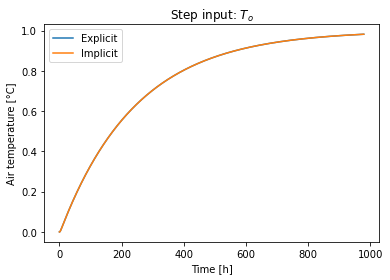

In [29]:
# plot results
fig, ax = plt.subplots()
ax.plot(t / 3600, θ_exp[-1, :], t / 3600, θ_imp[-1, :])
ax.set(xlabel='Time [h]',
       ylabel='Air temperature [°C]',
       title='Step input: $T_o$')
ax.legend(['Explicit', 'Implicit'])
plt.show()

> Figure 3. Step response to outdoor temperature $T_o$ obtained by explicit and implicit Euler integration of the state-space model. For small time steps, the two solutions are practically identical.

### Step input: indoor heat flow rate

Let's consider that the indoor heat flow rate $\dot{Q}_h$ has a step variation of 1 W (the outdoor temperature is zero, $T_o = 0$).

In [30]:
u = np.block([[np.zeros([1, n])],   # To = [0, 0, ... , 0]
              [np.ones([1, n])]])   # Qh = [1, 1, ... , 1]
pd.DataFrame(u)

,0,1,2,3,4,5,6,7,8,9,...,58711,58712,58713,58714,58715,58716,58717,58718,58719,58720
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


We initialize again to zero the temperature vector for explicit and implicit Euler.

In [31]:
θ_exp = np.zeros([no_θ, t.shape[0]])
θ_imp = np.zeros([no_θ, t.shape[0]])

The formula for Euler forward (or explicit) integration is

$$ \theta_{k+1} = (I + \Delta t A_s) \theta _k + \Delta t B_s u_k $$

and for Euler backward (or implicit) integration it is

$$\theta_{k+1} = (I - \Delta t A_s)^{-1} ( \theta _k + \Delta t B_s u_k )$$

In [32]:
for k in range(t.shape[0] - 1):
    θ_exp[:, k + 1] = (np.eye(no_θ) + Δt * As) @\
        θ_exp[:, k] + Δt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(np.eye(no_θ) - Δt * As) @\
        (θ_imp[:, k] + Δt * Bs @ u[:, k])

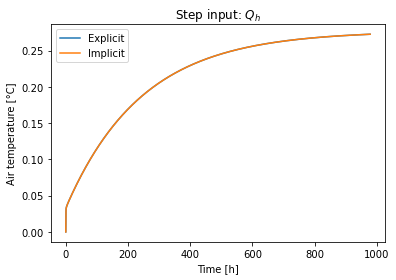

In [33]:
fig, ax = plt.subplots()
ax.plot(t / 3600, θ_exp[-1, :], t / 3600, θ_imp[-1, :])
ax.set(xlabel='Time [h]', ylabel='Air temperature [°C]', title='Step input: $Q_h$')
ax.legend(['Explicit', 'Implicit'])
plt.show()

> Figure 4. Step response to indoor heat flow rate $\dot{Q}_h$ obtained by explicit and implicit Euler integration of the state-space model.

### Simulation with outdoor temperature from weather data

#### Outdoor temperature from weather data
We want the weather data for Lyon from `start_date`to `end_date`. 

In [34]:
start_date = '2000-04-10'
end_date = '2000-05-15'
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'

From the weather data, only the air temperature, the direct solar radiation on a normal surface and the diffuse solar radiation on a horizontal surface are kept. 

In [35]:
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
# weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
weather = data[["temp_air"]]
del data

In the weather data file, each month is taken from another year. We will replace the years with only one value, e.g. 2000, then keep only the values between `start_date` and `end_date`.

In [36]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]
pd.DataFrame(weather)

,temp_air
2000-04-10 00:00:00+01:00,5.1
2000-04-10 01:00:00+01:00,4.5
2000-04-10 02:00:00+01:00,3.8
2000-04-10 03:00:00+01:00,3.2
2000-04-10 04:00:00+01:00,3.1
...,...
2000-05-15 19:00:00+01:00,14.0
2000-05-15 20:00:00+01:00,14.0
2000-05-15 21:00:00+01:00,12.6
2000-05-15 22:00:00+01:00,12.0


In [37]:
# time vector for weather data at 1 h time step
tw = np.arange(0, 3600 * weather.shape[0], 3600)
pd.DataFrame(tw)

,0
0,0
1,3600
2,7200
3,10800
4,14400
...,...
859,3092400
860,3096000
861,3099600
862,3103200


#### Resample the weather data
The time vector for simulation is at time step $\Delta t$.

In [38]:
# time vector for simulation
t = np.arange(0, 3600 * weather.shape[0], Δt)

The outdoor temperature $T_o$ (which is at a time step of $1 \, \mathrm{hour} = 3600 \, \mathrm{s}$) needs to be re-sampled at a time step equal to $\Delta t$.

In [39]:
# resample outdoor temperature at timestep Δt
θ_out = np.interp(t, tw, weather['temp_air'])
pd.DataFrame(θ_out, index=t, columns=['θ °C'])

,θ °C
0.00e+00,5.10
6.00e+01,5.09
1.20e+02,5.08
1.80e+02,5.07
2.40e+02,5.06
...,...
3.11e+06,12.00
3.11e+06,12.00
3.11e+06,12.00
3.11e+06,12.00


#### Input vector
The input vector $u$ is formed as a block vector from outdoor temperature and indoor heat flow $\dot{Q}_h$, which is zero.

In [40]:
# input vector [To, Qh]
u = np.block([[θ_out],
             [np.zeros(θ_out.shape[0])]])
pd.DataFrame(u, index=['To', 'Qh'])

,0,1,2,3,4,5,6,7,8,9,...,51830,51831,51832,51833,51834,51835,51836,51837,51838,51839
To,5.1,5.09,5.08,5.07,5.06,5.05,5.04,5.03,5.02,5.01,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
Qh,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Time integration
The responses are obtained by initializing the temperature vectors for explicit and implicit Euler and by integrating in time.

In [41]:
θ_exp = 15 * np.ones([no_θ, t.shape[0]])
θ_imp = 15 * np.ones([no_θ, t.shape[0]])
for k in range(u.shape[1] - 1):
    θ_exp[:, k + 1] = (np.eye(no_θ) + Δt * As) @\
        θ_exp[:, k] + Δt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(np.eye(no_θ) - Δt * As) @\
        (θ_imp[:, k] + Δt * Bs @ u[:, k])

#### Plot the results

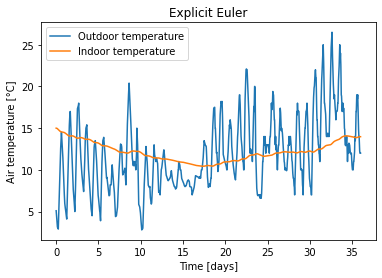

In [42]:
fig, ax = plt.subplots()
ax.plot(t / 3600 / 24, θ_out, label='Outdoor temperature')
ax.plot(t / 3600 / 24, θ_exp[-1, :], label='Indoor temperature')
ax.set(xlabel='Time [days]',
       ylabel='Air temperature [°C]',
       title='Explicit Euler')
ax.legend()
plt.show()

> Figure 5. Simulation of wall response to the variation of the outdoor temperature obtained with Euler **explicit** method for integration in time.

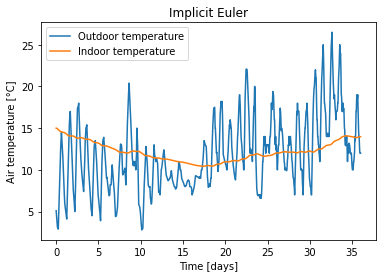

In [43]:
fig, ax = plt.subplots()
ax.plot(t / 3600 / 24, θ_out, label='Outdoor temperature')
ax.plot(t / 3600 / 24, θ_imp[-1, :], label='Indoor temperature')
ax.set(xlabel='Time [days]',
       ylabel='Air temperature [°C]',
       title='Implicit Euler')
ax.legend()
plt.show()

> Figure 6. Simulation of wall response to the variation of the outdoor temperature obtained with Euler **implicit** method for integration in time.

### Simulation with outdoor temperature from weather data by using Pandas

The same code as in the prevoius section with the differenec that Pandas are used for plotting the results of the simulations.

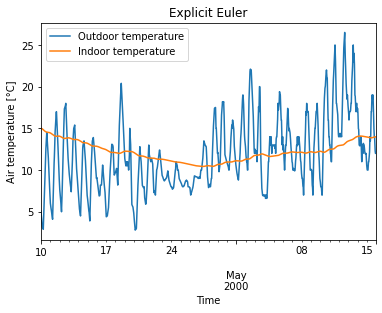

In [44]:
# Simulation with outdoor temperature from weather data with Pandas
# -----------------------------------------------------------------
start_date = '2000-04-10'
end_date = '2000-05-15'

# read data and keep air temperature
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air"]].copy()
del data

# replace years with year 2000 and select time interval
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

# resample weather data
data = weather['temp_air']
data = data.resample(str(Δt) + 'S').interpolate(method='linear')
data = data.rename('To').to_frame()

# indoor auxiliary heat
data['Qa'] = 0 * np.ones(data.shape[0])

# input vector
u = data[['To', 'Qa']]

# initial conditions
θ_exp = 15 * np.ones([As.shape[0], u.shape[0]])
θ_imp = 15 * np.ones([As.shape[0], u.shape[0]])

# time integration: Euler explicit & implicit
n_states = As.shape[0]
I = np.eye(n_states)

for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + Δt * As) @ θ_exp[:, k]\
        + Δt * Bs @ u.iloc[k, :]
    θ_imp[:, k + 1] = np.linalg.inv(I - Δt * As) @\
        (θ_imp[:, k] + Δt * Bs @ u.iloc[k, :])

data['θi_exp'] = θ_exp[-1, :]
data['θi_imp'] = θ_imp[-1, :]

ax = data[['To', 'θi_exp']].plot()
ax.legend(['Outdoor temperature', 'Indoor temperature'])
ax.set(xlabel='Time',
       ylabel='Air temperature [°C]',
       title='Explicit Euler')
plt.show()

> Figure 7. Simulation of wall response to the variation of the outdoor temperature obtained with Euler **explicit** method for integration in time.

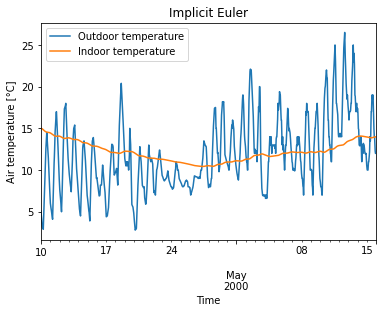

In [45]:
ax = data[['To', 'θi_imp']].plot()
ax.legend(['Outdoor temperature', 'Indoor temperature'])
ax.set(xlabel='Time',
       ylabel='Air temperature [°C]',
       title='Implicit Euler')
plt.show()

> Figure 8. Simulation of wall response to the variation of the outdoor temperature obtained with Euler **implicit** method for integration in time.

## Discussion

- Change the time step to do it slightly larger than the maximum time step. Compare the results of obtained with Euler explicit and Euler implicit methods.
- Exchnage the materials  of the layers so that layer 1 to be insulation and layer 2 to be concrete. Discuss the step responses and the simuation for weather. Give arguments for the advantages and the disadvanted of indoor and outdoor insulation. Explain the difference in the maximum time step for numerical integration.

## References

C. Ghiaus (2013) Causality issue in he heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, https://doi.org/10.1016/j.energy.2012.10.024, [hal-03605823](https://hal.archives-ouvertes.fr/hal-03605823/document)


# [Thermal circuit and state-space representation for a thermal circuit with capacities in some nodes: cubic building](03CubicBuilding.ipynb)

# [Thermal circuits assembling](04AssemblingCircuits.ipynb)

# [Switch between models: heating & cooling and free-running](05SwitchModels.ipynb)

# [Control input: heating & cooling and free-running](06Control_Input.ipynb)

# [Radiation coupled with convection](07Coupled_rad_convection.ipynb)

# [Sensible thermal load in steady-state](08Thermal_load.ipynb)

# [Air flow by ventilation](09Air_flow_ventilation.ipynb)